In [71]:
# Data transformation
library(dplyr)
library(readr)
library(lubridate)
# Data visualization
library(ggplot2)
library(scales)
# Custom R file
source("../Common/func.R")

In [79]:
# Read 'Climate_HistoricalNormals.csv' file
weatherDF <- read_csv(
    "../../data/Climate_HourlyWeather.csv",
    col_types = cols(
        `Date/Time` = col_datetime(),
        Year = col_integer(),
        Month = col_integer(),
        Day = col_integer(),
        Time = col_time(),
        `Data Quality` = col_character(),
        `Temp (C)` = col_double(),
        `Temp Flag` = col_character(),
        `Dew Point Temp (C)` = col_double(),
        `Dew Point Temp Flag` = col_character(),
        `Rel Hum (%)` = col_integer(),
        `Rel Hum Flag` = col_character(),
        `Wind Dir (10s deg)` = col_integer(),
        `Wind Dir Flag` = col_character(),
        `Wind Spd (km/h)` = col_integer(),
        `Wind Spd Flag` = col_character(),
        `Visibility (km)` = col_double(),
        `Visibility Flag` = col_character(),
        `Stn Press (kPa)` = col_double(),
        `Stn Press Flag` = col_character(),
        Hmdx = col_double(), # TBD
        `Hmdx Flag` = col_character(),
        `Wind Chill` = col_integer(), # TBD
        `Wind Chill Flag` = col_character(),
        Weather = col_character()
    )
)

# Cleanup of NA values
# All NAs are replaced with the median value of their respective column
cleanWeatherDF <- weatherDF %>%
    mutate(
        `Temp (C)`              =  coalesce(`Temp (C)`,             median(`Temp (C)`,              na.rm = TRUE)),
        `Dew Point Temp (C)`    =  coalesce(`Dew Point Temp (C)`,   median(`Dew Point Temp (C)`,    na.rm = TRUE)),
        `Rel Hum (%)`           =  coalesce(`Rel Hum (%)`,          median(`Rel Hum (%)`,           na.rm = TRUE)),
        `Wind Dir (10s deg)`    =  coalesce(`Wind Dir (10s deg)`,   median(`Wind Dir (10s deg)`,    na.rm = TRUE)),
        `Wind Spd (km/h)`       =  coalesce(`Wind Spd (km/h)`,      median(`Wind Spd (km/h)`,       na.rm = TRUE)),
        `Visibility (km)`       =  coalesce(`Visibility (km)`,      median(`Visibility (km)`,       na.rm = TRUE)),
        `Stn Press (kPa)`       =  coalesce(`Stn Press (kPa)`,      median(`Stn Press (kPa)`,       na.rm = TRUE)),
        Hmdx                    =  coalesce(Hmdx,                   median(Hmdx,                    na.rm = TRUE)),
        `Wind Chill`            =  coalesce(`Wind Chill`,           median(`Wind Chill`,            na.rm = TRUE))
    )

glimpse(cleanWeatherDF)

Rows: 17,520
Columns: 25
$ `Date/Time`           <dttm> 2012-04-01 00:00:00, 2012-04-01 01:00:00, 2012-~
$ Year                  <int> 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, ~
$ Month                 <int> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ~
$ Day                   <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ~
$ Time                  <time> 00:00:00, 01:00:00, 02:00:00, 03:00:00, 04:00:0~
$ `Data Quality`        <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, ~
$ `Temp (C)`            <dbl> 4.3, 4.4, 3.8, 2.8, 2.4, 3.0, 3.7, 4.7, 5.3, 5.9~
$ `Temp Flag`           <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, ~
$ `Dew Point Temp (C)`  <dbl> 2.3, 2.2, 1.6, 0.7, 0.4, 0.9, 1.7, 1.3, 1.3, 1.9~
$ `Dew Point Temp Flag` <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, ~
$ `Rel Hum (%)`         <dbl> 87, 86, 86, 86, 87, 86, 87, 79, 75, 75, 68, 61, ~
$ `Rel Hum Flag`        <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, ~
$ `Wind Dir (10

In [81]:
weatherDailyDF <- cleanWeatherDF %>%
    mutate(date = as.Date(`Date/Time`)) %>%
    rename(year = Year, month = Month, day = Day) %>%
    group_by(year, month, day, date) %>%
    summarise(
        avg_temp        = mean(`Temp (C)`),
        med_temp        = median(`Temp (C)`),
        avg_dewpt_temp  = mean(`Dew Point Temp (C)`),
        med_dewpt_temp  = median(`Dew Point Temp (C)`),
        avg_rel_hum_pct = mean(`Rel Hum (%)`),
        med_rel_hum_pct = median(`Rel Hum (%)`),
        avg_wind_dir    = mean(`Wind Dir (10s deg)`),
        med_wind_dir    = median(`Wind Dir (10s deg)`),
        avg_wind_spd    = mean(`Wind Spd (km/h)`),
        med_wind_spd    = median(`Wind Spd (km/h)`),
        avg_visib       = mean(`Visibility (km)`),
        med_visib       = median(`Visibility (km)`),
        avg_stn_press   = mean(`Stn Press (kPa)`),
        med_stn_press   = median(`Stn Press (kPa)`),
        avg_hmdx        = mean(Hmdx),
        med_hmdx        = median(Hmdx),
        avg_wind_chill  = mean(`Wind Chill`),
        med_wind_chill  = median(`Wind Chill`)
    )

weatherMonthlyDF <- cleanWeatherDF %>%
    rename(year = Year, month = Month) %>%
    group_by(year, month) %>%
    summarise(
        avg_temp        = mean(`Temp (C)`),
        med_temp        = median(`Temp (C)`),
        avg_dewpt_temp  = mean(`Dew Point Temp (C)`),
        med_dewpt_temp  = median(`Dew Point Temp (C)`),
        avg_rel_hum_pct = mean(`Rel Hum (%)`),
        med_rel_hum_pct = median(`Rel Hum (%)`),
        avg_wind_dir    = mean(`Wind Dir (10s deg)`),
        med_wind_dir    = median(`Wind Dir (10s deg)`),
        avg_wind_spd    = mean(`Wind Spd (km/h)`),
        med_wind_spd    = median(`Wind Spd (km/h)`),
        avg_visib       = mean(`Visibility (km)`),
        med_visib       = median(`Visibility (km)`),
        avg_stn_press   = mean(`Stn Press (kPa)`),
        med_stn_press   = median(`Stn Press (kPa)`),
        avg_hmdx        = mean(Hmdx),
        med_hmdx        = median(Hmdx),
        avg_wind_chill  = mean(`Wind Chill`),
        med_wind_chill  = median(`Wind Chill`)
    )



`summarise()` has grouped output by 'year', 'month', 'day'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


In [40]:
# Read 'Climate_HistoricalNormals.csv' file
weatherDF <- read_csv(
    "../../data/Climate_HourlyWeather.csv",
    col_types = cols(
        `Date/Time` = col_datetime(),
        Year = col_integer(),
        Month = col_integer(),
        Day = col_integer(),
        Time = col_time(),
        `Data Quality` = col_character(),
        `Temp (C)` = col_double(),
        `Temp Flag` = col_character(),
        `Dew Point Temp (C)` = col_double(),
        `Dew Point Temp Flag` = col_character(),
        `Rel Hum (%)` = col_integer(),
        `Rel Hum Flag` = col_character(),
        `Wind Dir (10s deg)` = col_integer(),
        `Wind Dir Flag` = col_character(),
        `Wind Spd (km/h)` = col_integer(),
        `Wind Spd Flag` = col_character(),
        `Visibility (km)` = col_double(),
        `Visibility Flag` = col_character(),
        `Stn Press (kPa)` = col_double(),
        `Stn Press Flag` = col_character(),
        Hmdx = col_double(), # TBD
        `Hmdx Flag` = col_character(),
        `Wind Chill` = col_integer(), # TBD
        `Wind Chill Flag` = col_character(),
        Weather = col_character()
    )
)

# Cleanup of NA values
# All NAs are replaced with the median value of their respective column
cleanWeatherDF <- weatherDF %>%
    mutate(
        `Temp (C)`              =  coalesce(`Temp (C)`, median(`Temp (C)`, na.rm = TRUE)),
        `Dew Point Temp (C)`    =  coalesce(`Dew Point Temp (C)`, median(`Dew Point Temp (C)`, na.rm = TRUE)),
        `Rel Hum (%)`           =  coalesce(`Rel Hum (%)`, median(`Rel Hum (%)`, na.rm = TRUE)),
        `Wind Dir (10s deg)`    =  coalesce(`Wind Dir (10s deg)`, median(`Wind Dir (10s deg)`, na.rm = TRUE)),
        `Wind Spd (km/h)`       =  coalesce(`Wind Spd (km/h)`, median(`Wind Spd (km/h)`, na.rm = TRUE)),
        `Visibility (km)`       =  coalesce(`Visibility (km)`, median(`Visibility (km)`, na.rm = TRUE)),
        `Stn Press (kPa)`       =  coalesce(`Stn Press (kPa)`, median(`Stn Press (kPa)`, na.rm = TRUE)),
        Hmdx                    =  coalesce(Hmdx, median(Hmdx, na.rm = TRUE)),
        `Wind Chill`            =  coalesce(`Wind Chill`, median(`Wind Chill`, na.rm = TRUE))
    )

glimpse(cleanWeatherDF)

Rows: 17,520
Columns: 25
$ `Date/Time`           <dttm> 2012-04-01 00:00:00, 2012-04-01 01:00:00, 2012-~
$ Year                  <int> 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, ~
$ Month                 <int> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ~
$ Day                   <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ~
$ Time                  <time> 00:00:00, 01:00:00, 02:00:00, 03:00:00, 04:00:0~
$ `Data Quality`        <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, ~
$ `Temp (C)`            <dbl> 4.3, 4.4, 3.8, 2.8, 2.4, 3.0, 3.7, 4.7, 5.3, 5.9~
$ `Temp Flag`           <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, ~
$ `Dew Point Temp (C)`  <dbl> 2.3, 2.2, 1.6, 0.7, 0.4, 0.9, 1.7, 1.3, 1.3, 1.9~
$ `Dew Point Temp Flag` <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, ~
$ `Rel Hum (%)`         <dbl> 87, 86, 86, 86, 87, 86, 87, 79, 75, 75, 68, 61, ~
$ `Rel Hum Flag`        <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, ~
$ `Wind Dir (10

In [42]:
weatherDailyDF <- cleanWeatherDF %>%
    mutate(date = as.Date(`Date/Time`)) %>%
    rename(year = Year, month = Month, day = Day) %>%
    group_by(year, month, day, date) %>%
    summarise(
        avg_temp        = mean(`Temp (C)`),
        med_temp        = median(`Temp (C)`),
        avg_dewpt_temp  = mean(`Dew Point Temp (C)`),
        med_dewpt_temp  = median(`Dew Point Temp (C)`),
        avg_rel_hum_pct = mean(`Rel Hum (%)`),
        med_rel_hum_pct = median(`Rel Hum (%)`),
        avg_wind_dir    = mean(`Wind Dir (10s deg)`),
        med_wind_dir    = median(`Wind Dir (10s deg)`),
        avg_wind_spd    = mean(`Wind Spd (km/h)`),
        med_wind_spd    = median(`Wind Spd (km/h)`),
        avg_visib       = mean(`Visibility (km)`),
        med_visib       = median(`Visibility (km)`),
        avg_stn_press   = mean(`Stn Press (kPa)`),
        med_stn_press   = median(`Stn Press (kPa)`),
        avg_hmdx        = mean(Hmdx),
        med_hmdx        = median(Hmdx),
        avg_wind_chill  = mean(`Wind Chill`),
        med_wind_chill  = median(`Wind Chill`)
    )

tempDailyDF <- weatherDailyDF %>%
    mutate(
        year    = as.integer(format(date, format = "%Y")),
        month   = as.integer(format(date, format = "%m")),
        day     = as.integer(format(date, format = "%d")),
        wDay    = as.integer(wday(date, week_start = 1)),

    ) %>%
    select(date, year, month, day, wDay, avg_temp, med_temp)

weatherMonthlyDF <- cleanWeatherDF %>%
    mutate(
        date = as.Date(`Date/Time`),
        year    = as.integer(format(date, format = "%Y")),
        month   = as.integer(format(date, format = "%m"))
    ) %>%
    group_by(year, month) %>%
    summarise(
        avg_temp        = mean(`Temp (C)`),
        med_temp        = median(`Temp (C)`),
        avg_dewpt_temp  = mean(`Dew Point Temp (C)`),
        med_dewpt_temp  = median(`Dew Point Temp (C)`),
        avg_rel_hum_pct = mean(`Rel Hum (%)`),
        med_rel_hum_pct = median(`Rel Hum (%)`),
        avg_wind_dir    = mean(`Wind Dir (10s deg)`),
        med_wind_dir    = median(`Wind Dir (10s deg)`),
        avg_wind_spd    = mean(`Wind Spd (km/h)`),
        med_wind_spd    = median(`Wind Spd (km/h)`),
        avg_visib       = mean(`Visibility (km)`),
        med_visib       = median(`Visibility (km)`),
        avg_stn_press   = mean(`Stn Press (kPa)`),
        med_stn_press   = median(`Stn Press (kPa)`),
        avg_hmdx        = mean(Hmdx),
        med_hmdx        = median(Hmdx),
        avg_wind_chill  = mean(`Wind Chill`),
        med_wind_chill  = median(`Wind Chill`)
    )

tempMonthlyDF <- weatherMonthlyDF %>%
    select(year, month, avg_temp, med_temp)

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


In [ ]:
# Whole House Water
whwDF <-    read_csv("../../data/Water_WHW.csv", show_col_types = FALSE) %>%
            convert_timeStamp("unix_ts")
# Whole House Electricity
wheDF <-    read_csv("../../data/Electricity_WHE.csv", show_col_types = FALSE) %>%
            convert_timeStamp("unix_ts") %>%
            mutate(avg_rate_modif = if_else(is.na(St - lag(St)), 0, St - lag(St)))
# Whole House Natural Gas
whgDF <-    read_csv("../../data/NaturalGas_WHG.csv", show_col_types = FALSE) %>%
            convert_timeStamp("unix_ts") %>%
            mutate(avg_rate_modif = avg_rate / 60)

In [ ]:
# Whole House Water
whwDaily <- whwDF %>%
    group_by(date) %>% 
    summarise(
        year        = factor(first(year)),
        month       = factor(first(month)),
        day         = factor(first(day)),
        wDay        = first(wday(date, week_start = 1)),
        consumption = sum(avg_rate) / 1000 # Liters to kilo Liters
    )
# Whole House Electricity
wheDaily <- wheDF %>%
    group_by(date) %>% 
    summarise(
        year        = factor(first(year)),
        month       = factor(first(month)),
        day         = factor(first(day)),
        wDay        = first(wday(date, week_start = 1)),
        consumption = sum(avg_rate_modif) / 1000 # Watts per hour to kWh
    )
# Whole House Natural Gas
whgDaily <- whgDF %>%
    group_by(date) %>% 
    summarise(
        year        = factor(first(year)),
        month       = factor(first(month)),
        day         = factor(first(day)),
        wDay        = first(wday(date, week_start = 1)),
        consumption = sum(avg_rate) # meter cube
    )

In [ ]:
all_metrics <- whwDaily %>%
    left_join(wheDaily, by = c("date"), suffix = c("_water", "_elec")) %>%
    left_join(whgDaily, by = c("date"), suffix = c("", "_gas")) %>%
    select(date, year_water, month_water, day_water, wDay_water, consumption_water, consumption_elec, consumption) %>%
    rename(
        year                = year_water,
        month               = month_water,
        day                 = day_water,
        wDay                = wDay_water,
        `consumption (kL)`  = consumption_water,
        `consumption (kWh)` = consumption_elec,
        `consumption (m3)`  = consumption
    )

In [ ]:
tempMetricsDF <- tempDF %>%
    left_join(all_metrics, by = c("date"), suffix = c("", "_all")) %>%
    select(-ends_with("_all"))

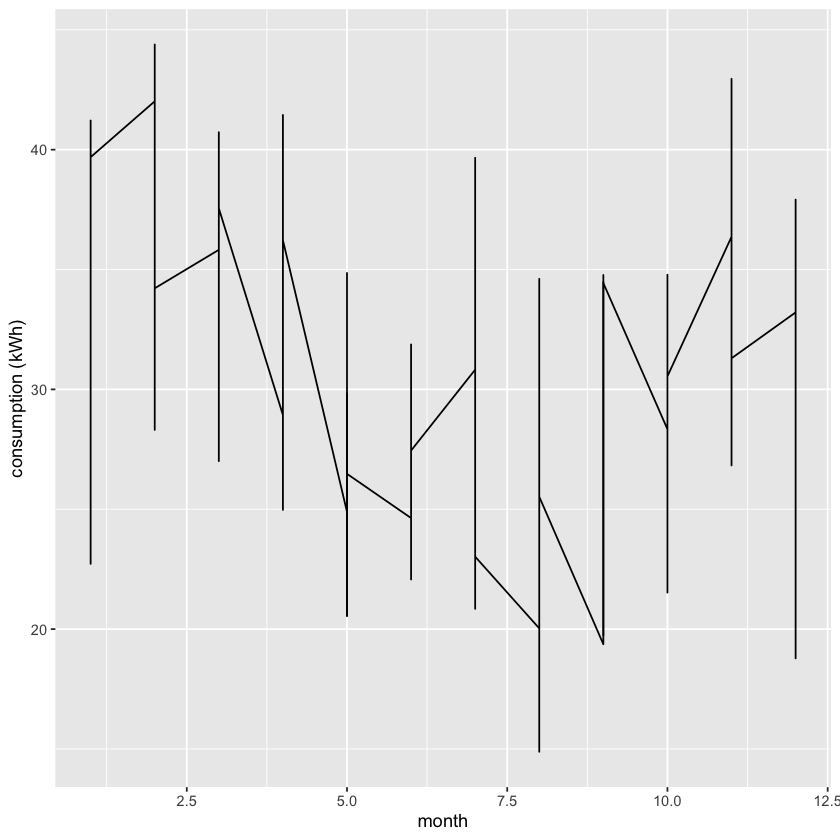

In [ ]:
tempMetricsDF %>%
    filter(year == 2013) %>%
    ggplot(aes(x = month, y = `consumption (kWh)`, group = year)) +
        geom_line()

In [44]:
# Whole House Electricity
wheMonthly <- wheDF %>%
    group_by(year, month) %>% 
    summarise(
        consumption = sum(avg_rate_modif) / 1000 # Watts per hour to kWh
    )

temp_elec_monthly <- tempMonthlyDF %>%
    left_join(wheMonthly, by = c("year", "month"), suffix = c("", "_temp"))

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


`geom_smooth()` using formula = 'y ~ x'


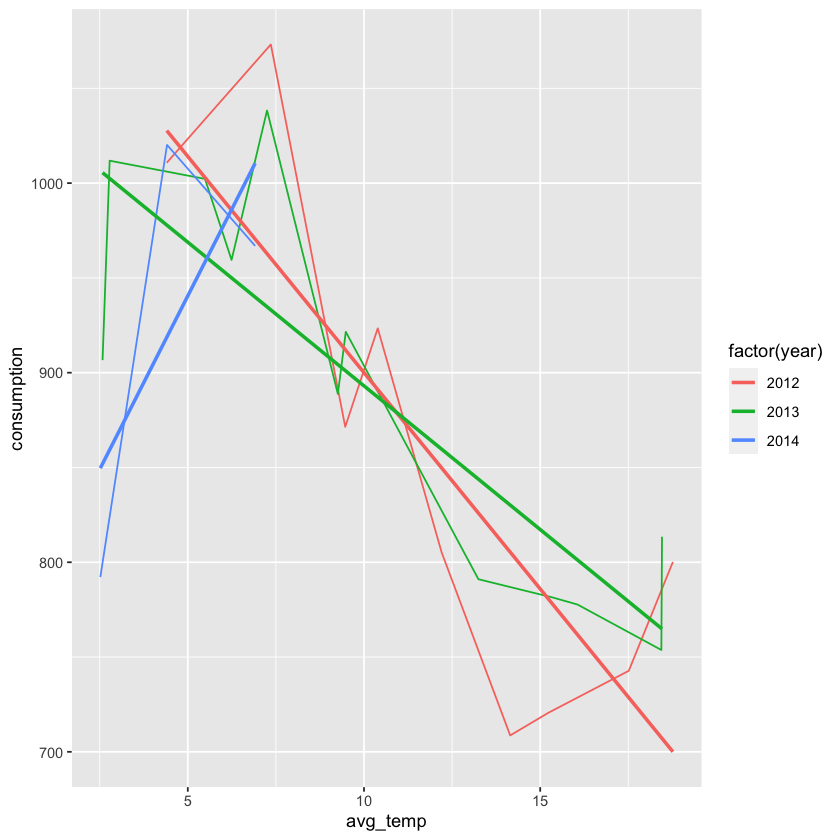

In [69]:
ggplot(temp_elec_monthly, aes(x = avg_temp, y = consumption, color = factor(year), group = year)) +
    geom_line() +
    geom_smooth(method = "lm", se = FALSE)

In [70]:
lmodel <- lm(consumption ~ avg_temp, temp_elec_monthly)
summary(lmodel)


Call:
lm(formula = consumption ~ avg_temp, data = temp_elec_monthly)

Residuals:
     Min       1Q   Median       3Q      Max 
-206.945  -29.092    8.708   46.684  148.762 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1038.005     33.935  30.588  < 2e-16 ***
avg_temp     -15.450      2.918  -5.295 2.59e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 76.33 on 22 degrees of freedom
Multiple R-squared:  0.5603,	Adjusted R-squared:  0.5403 
F-statistic: 28.04 on 1 and 22 DF,  p-value: 2.587e-05


In [58]:
library(broom)

In [65]:
qmodel <- glm(as.formula("consumption ~ avg_temp"), data = temp_elec_monthly, family = quasipoisson)
perf <- glance(pmodel)

[1] -330.272